## Observations and Insights 

In [246]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
from scipy.stats import sem
from scipy.stats import linregress

# Study data files
mousecsv = '../Resources/Mouse_metadata.csv'
studycsv = '../Resources/Study_results.csv'

# Read the mouse data and the study results
mouse_data = pd.read_csv(mousecsv)
study_data = pd.read_csv(studycsv)

# Combine the data into a single dataset
combined_data = pd.merge(mouse_data, study_data, how='left', on=['Mouse ID'])

# Display the data table for preview
combined_data.head()

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1


In [247]:
# Checking the number of mice.

# Find the total number of mice in the study by doing a count of the Mouse IDs in mouse_data
print(mouse_data['Mouse ID'].count())

# Group the study_data by Timepoint, and count the number of mice measured at each timepoint
check = study_data.groupby(['Timepoint'])
check.count()

# Compare the total number of mice in the study to the number of mice included at each timepoint
#---Total Mice (249) < Mouse ID count for Timepoint 0 (250) --> shows that one mouse was measured twice 

249


,Mouse ID,Tumor Volume (mm3),Metastatic Sites
Timepoint,,,
0,250,250,250
5,238,238,238
10,223,223,223
15,207,207,207
20,195,195,195
25,183,183,183
30,171,171,171
35,154,154,154
40,142,142,142


In [248]:
# Getting the duplicate mice by ID number that shows up for Mouse ID and Timepoint. 

# Check combined_data for mice that were measured more than once per Timepoint and separate them out into a variable 
#---use .duplicated() and have it look at both the Mouse ID *AND* Timepoint columns 
dupMouse_check = combined_data.duplicated(subset=["Mouse ID", "Timepoint"])

# For the dupMouse_check subset of combined_data, extract the unique values in the 'Mouse ID' column into a list
dupMouse_ID = combined_data[dupMouse_check]['Mouse ID'].unique()

# Print out the list to see the duplicated mouse's ID 
print(dupMouse_ID)

#-------------------------------------------------------------
#CAN ALSO DO:
# Separate out the rows for Timepoint 0 from study_data
#time0 = study_data.loc[study_data['Timepoint'] == 0, :]

# Count how many times each Mouse ID appears in time0 --> time0['Mouse ID'].value_counts()
# Look for those with counts greater than 1 --> .loc[lambda x : x>1]
# Extract the Mouse IDs for those mice into a list --> .index.tolist()
#dupMouse_ID = time0['Mouse ID'].value_counts().loc[lambda x : x>1].index.tolist()

#print(dupMouse_ID)


['g989']


In [249]:
# Optional: Get all the data for the duplicate mouse ID. 
dupMouse_data = combined_data.loc[combined_data['Mouse ID'].isin(dupMouse_ID)]

dupMouse_data


,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
908,g989,Propriva,Female,21,26,0,45.000000,0
909,g989,Propriva,Female,21,26,0,45.000000,0
910,g989,Propriva,Female,21,26,5,48.786801,0
911,g989,Propriva,Female,21,26,5,47.570392,0
912,g989,Propriva,Female,21,26,10,51.745156,0
913,g989,Propriva,Female,21,26,10,49.880528,0
914,g989,Propriva,Female,21,26,15,51.325852,1
915,g989,Propriva,Female,21,26,15,53.442020,0
916,g989,Propriva,Female,21,26,20,55.326122,1
917,g989,Propriva,Female,21,26,20,54.657650,1


In [250]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.
combined_clean = combined_data.drop(dupMouse_data.index)

# Check that the drop was successful by looking through combined_clean and pulling out all the rows for the duplicated mice
#---if successful, printing the results of the .loc[] should give an empty dataframe
drop_check = combined_clean.loc[combined_clean['Mouse ID'].isin(dupMouse_ID)]
print(drop_check)

# As the checks were passed, display the cleaned dataset for preview
combined_clean.head()

Empty DataFrame
Columns: [Mouse ID, Drug Regimen, Sex, Age_months, Weight (g), Timepoint, Tumor Volume (mm3), Metastatic Sites]
Index: []


,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1


In [251]:
# Checking the number of mice in the clean DataFrame.

# Double check that the number of unique Mouse IDs included in combined_clean dropped from the original total of 249
#---in this case, since there was only one duplicated mouse, the result should equal 248
print(len(combined_clean['Mouse ID'].unique()))


248


## Summary Statistics

In [252]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

# Use groupby and summary statistical methods to calculate the following properties of each drug regimen: 
# mean, median, variance, standard deviation, and SEM of the tumor volume. 
# Assemble the resulting series into a single summary dataframe.

combined_byDrugReg = combined_clean.groupby(['Drug Regimen'])
print(combined_byDrugReg.count())

drugReg_means = combined_byDrugReg['Tumor Volume (mm3)'].mean()
print(drugReg_means)

drugReg_medians = combined_byDrugReg['Tumor Volume (mm3)'].median()
print(drugReg_medians)

drugReg_vars = combined_byDrugReg['Tumor Volume (mm3)'].var()
print(drugReg_vars)

drugReg_stdevs = combined_byDrugReg['Tumor Volume (mm3)'].std()
print(drugReg_stdevs)

drugReg_sems = combined_byDrugReg['Tumor Volume (mm3)'].sem()
print(drugReg_sems)

tumorVolSum_df = pd.concat([drugReg_means, drugReg_medians, drugReg_vars, drugReg_stdevs, drugReg_sems],
                           axis=1, keys= ['Mean', 'Median', 'Variance', 'Std. Dev.', 'SEM'])
tumorVolSum_df


              Mouse ID  Sex  Age_months  Weight (g)  Timepoint  \
Drug Regimen                                                     
Capomulin          230  230         230         230        230   
Ceftamin           178  178         178         178        178   
Infubinol          178  178         178         178        178   
Ketapril           188  188         188         188        188   
Naftisol           186  186         186         186        186   
Placebo            181  181         181         181        181   
Propriva           148  148         148         148        148   
Ramicane           228  228         228         228        228   
Stelasyn           181  181         181         181        181   
Zoniferol          182  182         182         182        182   

              Tumor Volume (mm3)  Metastatic Sites  
Drug Regimen                                        
Capomulin                    230               230  
Ceftamin                     178               1

,Mean,Median,Variance,Std. Dev.,SEM
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


In [253]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

# Using the aggregation method, produce the same summary statistics in a single line of code

tumorVolSum_dfOneLine = combined_byDrugReg.agg(['mean', 'median', 'var', 'std', 'sem'])['Tumor Volume (mm3)']
tumorVolSum_dfOneLine


,mean,median,var,std,sem
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


## Bar and Pie Charts

              Timepoint 0  Timepoint 5  Timepoint 10  Timepoint 15  \
Drug Regimen                                                         
Capomulin              25           25            25            24   
Ceftamin               25           21            20            19   
Infubinol              25           25            21            21   
Ketapril               25           23            22            19   
Naftisol               25           23            21            21   
Placebo                25           24            24            20   
Propriva               24           23            21            15   
Ramicane               25           25            24            24   
Stelasyn               24           23            21            21   
Zoniferol              25           24            22            21   

              Timepoint 20  Timepoint 25  Timepoint 30  Timepoint 35  \
Drug Regimen                                                           
Capomulin      

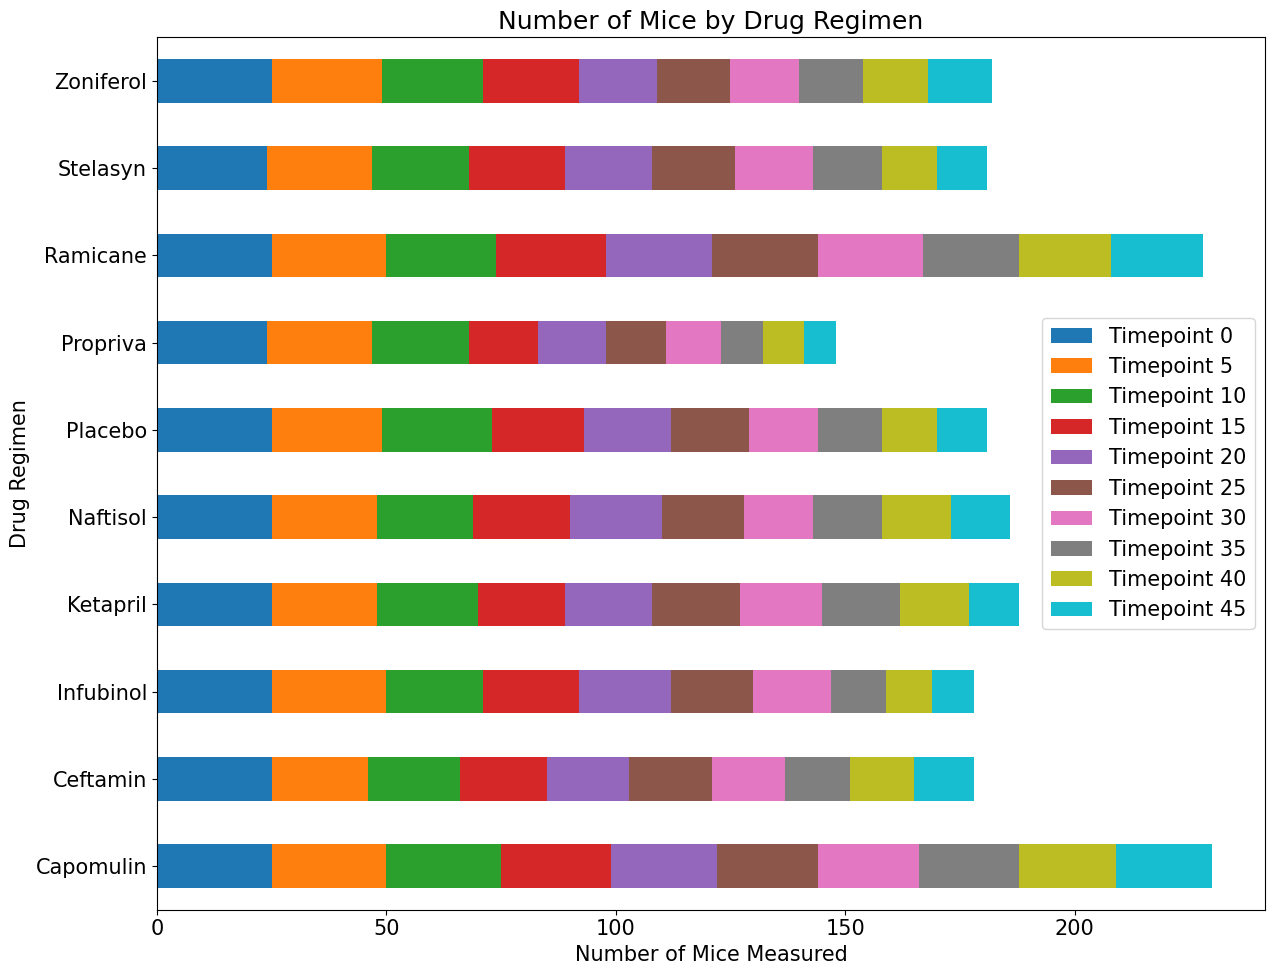

In [254]:
# Generate a bar plot showing the total number of timepoints for all mice tested for each drug regimen using Pandas.

drugReg_time0 = combined_clean[combined_clean['Timepoint'] == 0].groupby(['Drug Regimen'])['Mouse ID'].count()
drugReg_time5 = combined_clean[combined_clean['Timepoint'] == 5].groupby(['Drug Regimen'])['Mouse ID'].count()
drugReg_time10 = combined_clean[combined_clean['Timepoint'] == 10].groupby(['Drug Regimen'])['Mouse ID'].count()
drugReg_time15 = combined_clean[combined_clean['Timepoint'] == 15].groupby(['Drug Regimen'])['Mouse ID'].count()
drugReg_time20 = combined_clean[combined_clean['Timepoint'] == 20].groupby(['Drug Regimen'])['Mouse ID'].count()
drugReg_time25 = combined_clean[combined_clean['Timepoint'] == 25].groupby(['Drug Regimen'])['Mouse ID'].count()
drugReg_time30 = combined_clean[combined_clean['Timepoint'] == 30].groupby(['Drug Regimen'])['Mouse ID'].count()
drugReg_time35 = combined_clean[combined_clean['Timepoint'] == 35].groupby(['Drug Regimen'])['Mouse ID'].count()
drugReg_time40 = combined_clean[combined_clean['Timepoint'] == 40].groupby(['Drug Regimen'])['Mouse ID'].count()
drugReg_time45 = combined_clean[combined_clean['Timepoint'] == 45].groupby(['Drug Regimen'])['Mouse ID'].count()

drugReg_times_miceCounts = pd.DataFrame({'Timepoint 0': drugReg_time0,
                                        'Timepoint 5': drugReg_time5,
                                        'Timepoint 10': drugReg_time10,
                                        'Timepoint 15': drugReg_time15,
                                        'Timepoint 20': drugReg_time20,
                                        'Timepoint 25': drugReg_time25,
                                        'Timepoint 30': drugReg_time30,
                                        'Timepoint 35': drugReg_time35,
                                        'Timepoint 40': drugReg_time40,
                                        'Timepoint 45': drugReg_time45})
print(drugReg_times_miceCounts)

plt.rcParams.update({'font.size': 15})
drugReg_times_miceCounts.plot(kind='barh',stacked=True,figsize=(13,10),title='Number of Mice by Drug Regimen')
plt.xlabel('Number of Mice Measured')
plt.ylabel('Drug Regimen')
plt.tight_layout()

plt.savefig('Charts/NumberofMicebyDrugRegimen_bar_pandas.png')
plt.show()

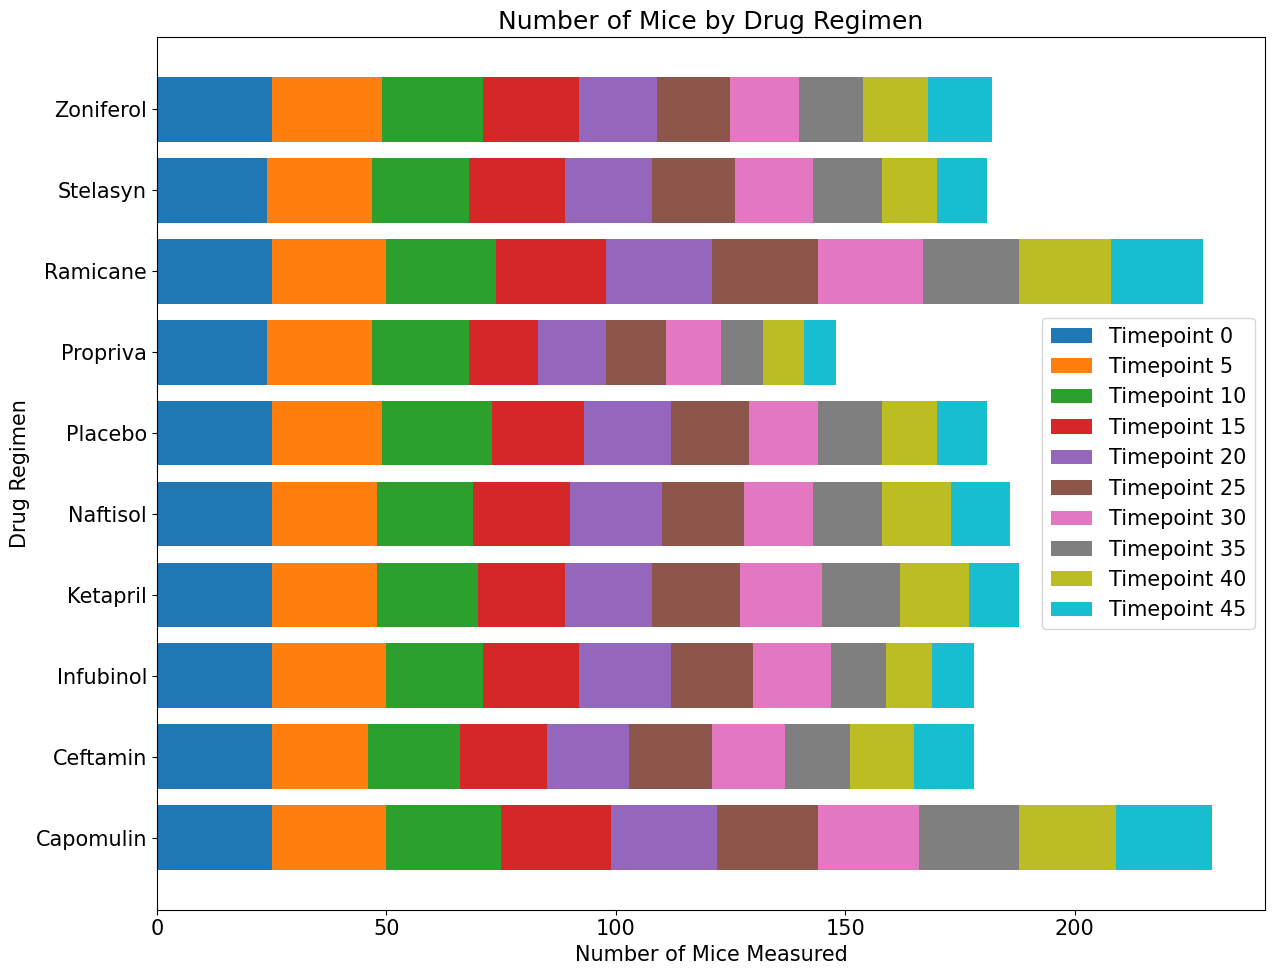

In [255]:
# Generate a bar plot showing the total number of timepoints for all mice tested for each drug regimen using pyplot.

times = ['Timepoint 0','Timepoint 5','Timepoint 10','Timepoint 15','Timepoint 20',
         'Timepoint 25','Timepoint 30','Timepoint 35','Timepoint 40','Timepoint 45']
colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd',
          '#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf']

fig, ax = plt.subplots(1, figsize=(13,10))

left = len(drugReg_times_miceCounts) * [0]
for idx, drug in enumerate(times):
    plt.barh(drugReg_times_miceCounts.index, drugReg_times_miceCounts[drug], left=left, color=colors[idx])
    left = left + drugReg_times_miceCounts[drug]
    
plt.title('Number of Mice by Drug Regimen')
plt.xlabel('Number of Mice Measured')
plt.ylabel('Drug Regimen')
plt.legend(times)
plt.tight_layout()

plt.savefig('Charts/NumberofMicebyDrugRegimen_bar_pyplot.png')
plt.show()

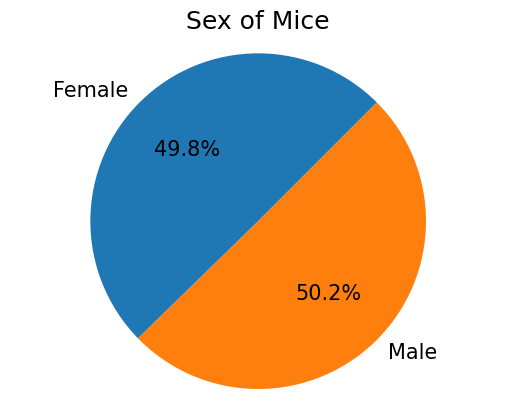

In [256]:
# Generate a pie plot showing the distribution of female versus male mice using Pandas

sex_miceCounts = pd.DataFrame(mouse_data.groupby(['Sex'])['Mouse ID'].count())

#sex_miceCounts = pd.DataFrame(mouseData_bySex['Mouse ID'].count())

#print(sex_miceCounts)

sex_miceCounts.plot(kind='pie', y='Mouse ID', title='Sex of Mice', autopct='%1.1f%%',
                    startangle=45, legend=False, ylabel='')
plt.axis('equal')
plt.show()
                    
#plt.savefig('Charts/SexofMice_pie_pandas.png')



['Female', 'Male']
[124, 125]


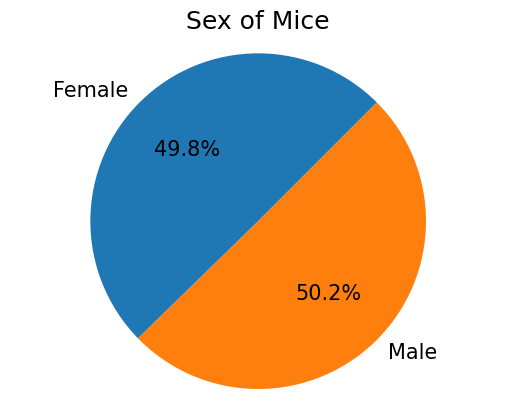

In [257]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot

sex = list(sex_miceCounts.index.values)
print(sex)

sexCounts = list(sex_miceCounts['Mouse ID'])
print(sexCounts)

plt.pie(sexCounts, labels=sex, autopct='%1.1f%%', startangle=45)
plt.title('Sex of Mice')
plt.axis('equal')

plt.savefig('Charts/SexofMice_pie_pyplot.png')
plt.show()

## Quartiles, Outliers and Boxplots

In [258]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin

# Start by getting the last (greatest) timepoint for each mouse

topdrugsList = ['Capomulin', 'Ramicane', 'Infubinol', 'Ceftamin']

topdrugs_data = combined_data[combined_data['Drug Regimen'].isin(topdrugsList)]
print(topdrugs_data)

topdrugs_df = topdrugs_data[['Mouse ID', 'Drug Regimen', 'Timepoint', 'Tumor Volume (mm3)']]
print(topdrugs_df)

topdrugs_lastTime = topdrugs_df.groupby(['Drug Regimen','Mouse ID']).agg(lastTime=('Timepoint', max),
                                                                         lastVol=('Tumor Volume (mm3)',lambda x: x.iloc[-1]))
#topdrugs_lastTime

topdrugs_lastTime_df = topdrugs_lastTime.reset_index()
topdrugs_lastTime_df

     Mouse ID Drug Regimen     Sex  Age_months  Weight (g)  Timepoint  \
0        k403     Ramicane    Male          21          16          0   
1        k403     Ramicane    Male          21          16          5   
2        k403     Ramicane    Male          21          16         10   
3        k403     Ramicane    Male          21          16         15   
4        k403     Ramicane    Male          21          16         20   
...       ...          ...     ...         ...         ...        ...   
1868     z581    Infubinol  Female          24          25         25   
1869     z581    Infubinol  Female          24          25         30   
1870     z581    Infubinol  Female          24          25         35   
1871     z581    Infubinol  Female          24          25         40   
1872     z581    Infubinol  Female          24          25         45   

      Tumor Volume (mm3)  Metastatic Sites  
0              45.000000                 0  
1              38.825898         

,Drug Regimen,Mouse ID,lastTime,lastVol
0,Capomulin,b128,45,38.982878
1,Capomulin,b742,45,38.939633
2,Capomulin,f966,20,30.485985
3,Capomulin,g288,45,37.074024
4,Capomulin,g316,45,40.159220
...,...,...,...,...
95,Ramicane,s508,45,30.276232
96,Ramicane,u196,45,40.667713
97,Ramicane,w678,5,43.166373
98,Ramicane,y449,15,44.183451


In [259]:
# Create empty list to fill with tumor vol data (for plotting)
topdrugSubsets = []

# For each drug regimen, calculate the quartiles, IQR, and determine any potential outliers. 
#---use topdrugsList created earlier
for drug in topdrugsList:
    
    drug_df = topdrugs_lastTime_df.loc[topdrugs_lastTime_df['Drug Regimen'] == drug]
    
    drug_lastVols = drug_df['lastVol']
    
    topdrugSubsets.append(drug_lastVols)
    
    quartiles = drug_lastVols.quantile([.25, .5, .75])
    lowerq = quartiles[.25]
    upperq = quartiles[.75]
    IQR = upperq - lowerq
    
    lower_bound = lowerq - (1.5*IQR)
    upper_bound = upperq + (1.5*IQR)
    
    outliers = (drug_lastVols.loc[(drug_df['lastVol'] >= upper_bound) |
                                  (drug_df['lastVol'] <= lower_bound)]).tolist()
    
    print('-------------------------------------------------------------')
    print(f"{drug} Quartiles and Outliers:")
    print(f" - The lower quartile of {drug} is: {lowerq}")
    print(f" - The upper quartile of {drug}  is: {upperq}")
    print(f" - The interquartile range of {drug}  is: {IQR}")
    print(f" - The the median of {drug}  is: {quartiles[0.5]} ")
    print(f" - Values below {lower_bound} could be outliers.")
    print(f" - Values above {upper_bound} could be outliers.")
    if outliers == []:
        print(f" - Outliers for {drug} include: NONE")
    else: 
        print(f" - Outliers for {drug} include: {outliers}")

print('-------------------------------------------------------------')


-------------------------------------------------------------
Capomulin Quartiles and Outliers:
 - The lower quartile of Capomulin is: 32.37735684
 - The upper quartile of Capomulin  is: 40.1592203
 - The interquartile range of Capomulin  is: 7.781863460000004
 - The the median of Capomulin  is: 38.1251644 
 - Values below 20.70456164999999 could be outliers.
 - Values above 51.83201549 could be outliers.
 - Outliers for Capomulin include: NONE
-------------------------------------------------------------
Ramicane Quartiles and Outliers:
 - The lower quartile of Ramicane is: 31.56046955
 - The upper quartile of Ramicane  is: 40.65900627
 - The interquartile range of Ramicane  is: 9.098536719999998
 - The the median of Ramicane  is: 36.56165229 
 - Values below 17.912664470000003 could be outliers.
 - Values above 54.30681135 could be outliers.
 - Outliers for Ramicane include: NONE
-------------------------------------------------------------
Infubinol Quartiles and Outliers:
 - The lo

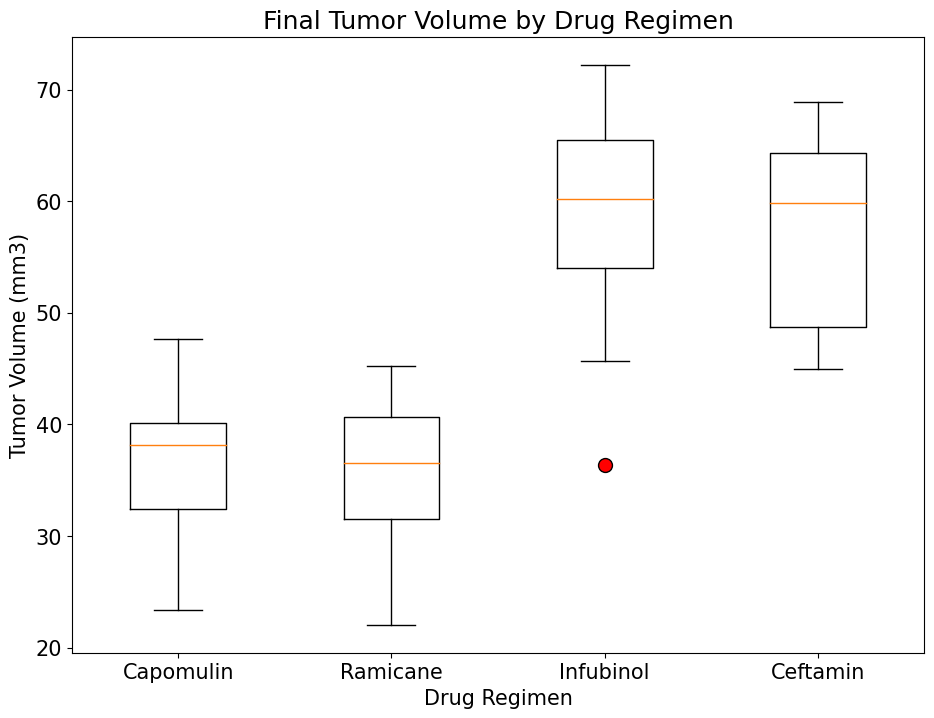

In [260]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest

flierprops = dict(marker='o', markerfacecolor='r', markersize=10, markeredgecolor='black')

fig1, ax = plt.subplots(figsize=(11,8))
ax.boxplot(topdrugSubsets, flierprops=flierprops)

ax.set_title('Final Tumor Volume by Drug Regimen')
ax.set_xlabel('Drug Regimen')
ax.set_ylabel('Tumor Volume (mm3)')
plt.xticks([1,2,3,4], topdrugsList)

plt.savefig('Charts/FinalTumorVolumebyDrugRegimen_BoxandWhisker.png')
plt.show()

## Line and Scatter Plots

[45.0, 43.87849569, 37.61494768, 38.17723195, 36.86687576, 33.94994037, 32.95967078, 28.32853059, 25.47214326, 23.34359787]
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45]


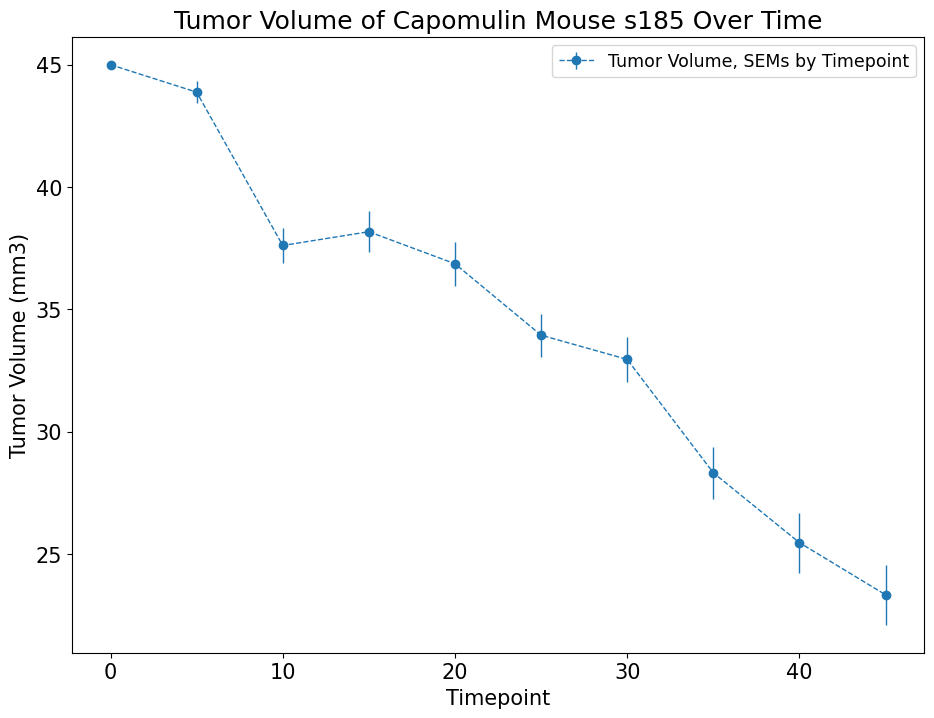

In [261]:
# Generate a line plot of tumor volume vs. time point for ONE mouse treated with Capomulin

capomulin_df = combined_data[combined_data['Drug Regimen'] == 'Capomulin']
capomulin_df

capomulin_tumorVol_byTime = capomulin_df.groupby(['Timepoint']).agg(tumorVol_Mean=('Tumor Volume (mm3)', np.mean),
                                                                    tumorVol_SEM=('Tumor Volume (mm3)', st.sem))
capomulin_tumorVol_byTime

capomulin_Mouse = capomulin_df[capomulin_df['Mouse ID'] == 's185']
capomulin_Mouse
                                                                    
capomulin_Mouse_tumorVol = capomulin_Mouse['Tumor Volume (mm3)'].tolist()
print(capomulin_Mouse_tumorVol)

timepoints = capomulin_Mouse['Timepoint'].tolist()
print(timepoints)

fig1, ax1 = plt.subplots(figsize=(11,8))

plt.errorbar(timepoints, capomulin_Mouse_tumorVol, yerr=capomulin_tumorVol_byTime['tumorVol_SEM'],
             fmt='--o', linewidth=1, label='Tumor Volume, SEMs by Timepoint')

plt.title('Tumor Volume of Capomulin Mouse s185 Over Time')
plt.xlabel('Timepoint')
plt.ylabel('Tumor Volume (mm3)')
plt.legend(loc='best', fontsize='small', fancybox=True)

plt.savefig('Charts/TumorVolumeofCapomulinMouses185OverTime_line.png')
plt.show()



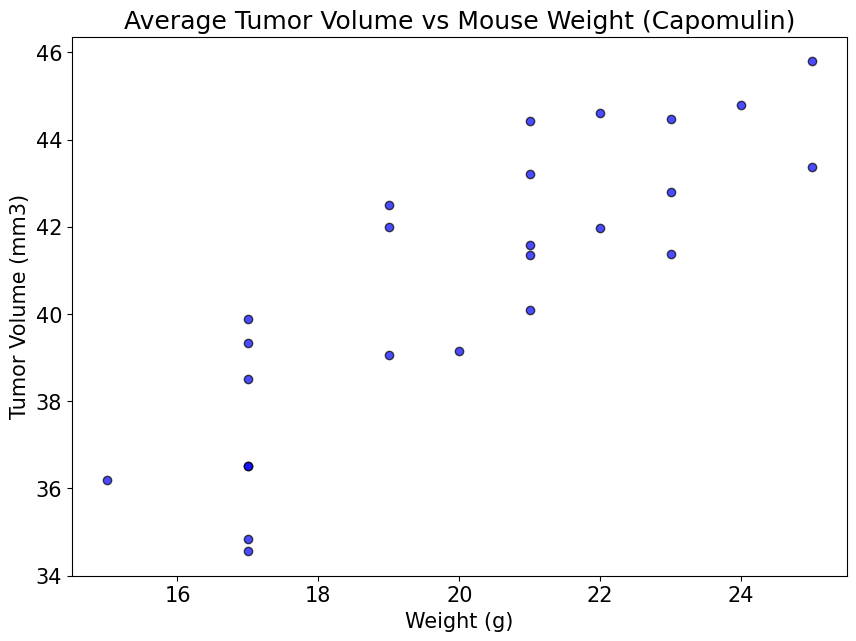

In [262]:
# Generate a scatter plot of average tumor volume vs. mouse weight for all the mice treated with the Capomulin regimen

capomulin_tumorVol_byWeight = capomulin_df.groupby(['Mouse ID']).agg(tumorVol_Mean=('Tumor Volume (mm3)', np.mean),
                                                                     weight=('Weight (g)', np.mean))
capomulin_tumorVol_byWeight

fig = plt.figure(figsize=(10,7))
plt.scatter(capomulin_tumorVol_byWeight['weight'], capomulin_tumorVol_byWeight['tumorVol_Mean'],
           marker='o', facecolors='blue', edgecolors='black', alpha=.7)
plt.title('Average Tumor Volume vs Mouse Weight (Capomulin)')
plt.xlabel('Weight (g)')
plt.ylabel('Tumor Volume (mm3)')

plt.savefig('Charts/AverageTumorVolumevsMouseWeight_scatter.png')
plt.show()


## Correlation and Regression

The correlation between average mouse weight and average tumor volume is 0.84
The coefficient of determination is 0.71
The equation of the regression line is y = 0.95x + 21.55


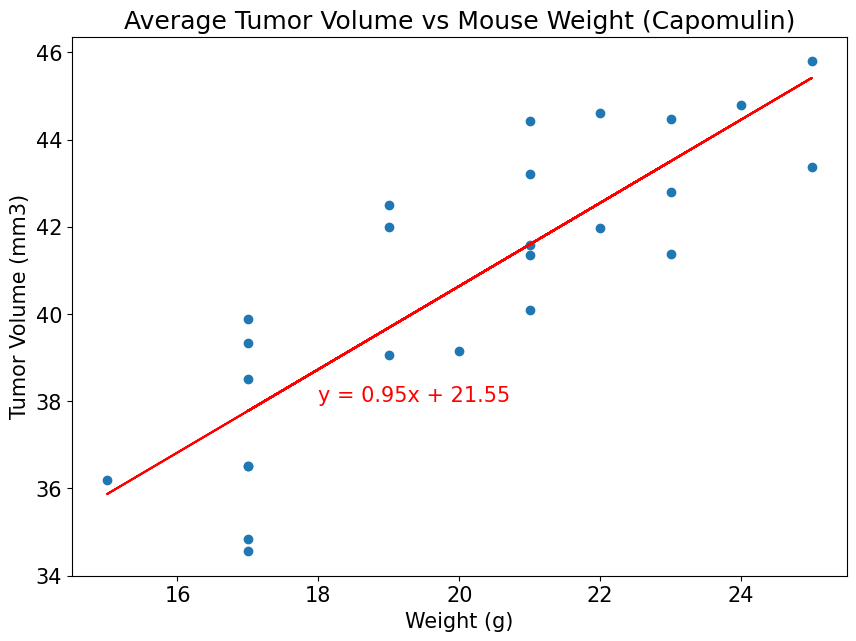

In [272]:
# Calculate the correlation coefficient and linear regression model 
# for mouse weight and average tumor volume for the Capomulin regimen

weightAvg = capomulin_tumorVol_byWeight['weight']
tumorvolAvg = capomulin_tumorVol_byWeight['tumorVol_Mean']

(slope, intercept, rvalue, pvalue, stderr) = linregress(weightAvg, tumorvolAvg)
regressLine = weightAvg * slope + intercept
regressEq = 'y = ' + str(round(slope,2)) + 'x + ' + str(round(intercept,2))
print(f'The correlation between average mouse weight and average tumor volume is {round(rvalue,2)}')
print(f"The coefficient of determination is {round(rvalue**2,2)}")
print(f"The equation of the regression line is {regressEq}")

fig1 = plt.figure(figsize=(10,7))
plt.scatter(weightAvg, tumorvolAvg)
plt.plot(weightAvg, regressLine, 'r-')
plt.annotate(regressEq, (18,38), fontsize=15, color='red')
plt.title('Average Tumor Volume vs Mouse Weight (Capomulin)')
plt.xlabel('Weight (g)')
plt.ylabel('Tumor Volume (mm3)')

plt.savefig('Charts/AverageTumorVolumevsMouseWeight_regression.png')
plt.show()